## Calculating the RMS of Sea Level Anomaly

The principle here is that the model has absoluate sea level, $\eta$. We also save $\eta^2$. But these are absolute values, not the anomaly from the mean. To calculate the RMS of the Sea Level Anomaly, we want to find

$$R = \left(\overline{(\eta - \overline{\eta})^2}\right)^{1/2}$$
$$ = \left(\overline{\eta^2 - 2 \eta \overline{\eta} + \overline{\eta}^2}\right)^{1/2}$$
$$ = \left(\overline{\eta^2} - 2 \overline{\eta} \overline{\eta} + \overline{\eta}^2\right)^{1/2}$$
$$ = \left(\overline{\eta^2} -  \overline{\eta}^2\right)^{1/2}$$

Thus, we can take the temporal mean of $\eta$ and $eta^2$ to find $R$.

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 42699:127.0.0.1:42699 vdi-n7.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:41714 Dashboard: http://127.0.0.1:42699/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [4]:
def global_map_rms(sla_rms,geolon_t,geolat_t):
    clev = np.arange(0,0.4,0.01)
    clev2 = np.arange(-140,140.01,10)
    
    map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-60.,61.,30.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(-180.,181.,90.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,sla_rms, cmap=cm.cm.matter, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    #map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    #map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139982416451328 and this is thread id 139980039948032.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f4fcfbaf2d0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139982416451328 and this is thread id 139980039948032.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f4fcfbbbc70>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139982416451328 and this is thread id 139980039948032.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f4fcce0ad50>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139982416451328 and this is thread id 139980039948032.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f4fcfdb03b0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139982416451328 and this is thread id 139980039948032.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f4fcfbbbab0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:43528 remote=tcp://127.0.0.1:41714>


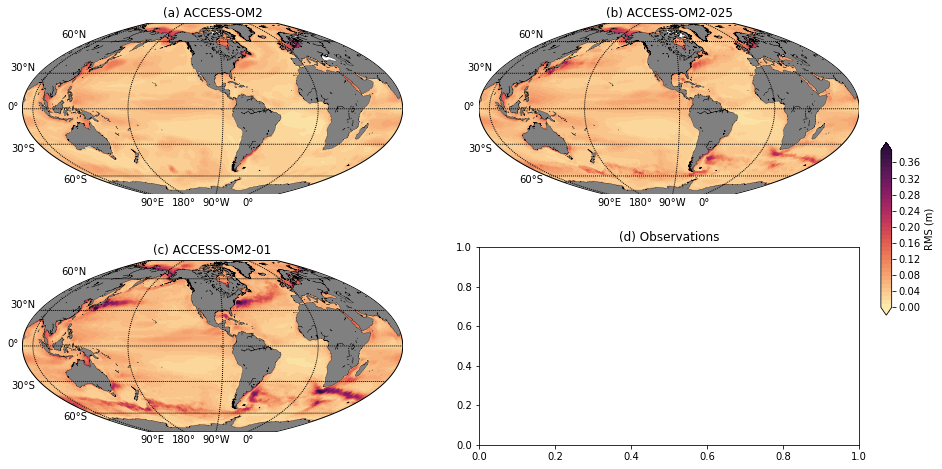

In [5]:
plt.figure(figsize(15,8))

plot_labels=['(a) ','(b) ','(c) ']

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    if (ekey == '01deg'):
        sea_level = cc.get_nc_variable(expt,'ocean_daily.nc','eta_t',
                                n=n_files,time_units=time_units, offset=offset)\
                                .sel(time=slice(pd.datetime(1998,1,1),None)).mean('time')
    else:
        sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                                n=n_files,time_units=time_units, offset=offset)\
                                .sel(time=slice(pd.datetime(1998,1,1),None)).mean('time')
    
    sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                n=n_files,time_units=time_units, offset=offset)\
                                .sel(time=slice(pd.datetime(1998,1,1),None)).mean('time')
    sla_rms = (sea_levelsq - sea_level**(2.0))**(0.5)
    
    geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1).mean('time')
    geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1).mean('time')
    
    label=plot_labels[i]
    
    plt.subplot(2,2,i+1)
    p1 =global_map_rms(sla_rms,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    

plt.subplot(224)
plt.title('(d) Observations')

ax3 = plt.axes([0.92,0.35,0.01,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('RMS (m)')
savefigure('sea_level_anomaly_rms')
